In [1]:
## Path for modules

import warnings
warnings.filterwarnings("ignore")

import sys

import numpy as np
import xarray as xr

from netCDF4 import Dataset

sys.path.insert(0,"/mnt/meom/workdir/henelle/Notebooks/git/xscale")
import xscale
import xscale.spectral.fft as xfft
from xscale.spectral.tools import plot_spectrum
import xscale.signal.generator as xgen

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import numpy.ma as ma

import matplotlib.cm as mplcm
import matplotlib.colors as colors
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

seq_cmap = mplcm.Blues
div_cmap = mplcm.seismic

import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import date, datetime
from xhistogram.xarray import histogram

import pandas as pd

import seaborn as sns
sns.set(color_codes=True)

import dask 

import os 
import time 
import glob
today=date.today()



params = {'figure.figsize' : (18, 10),'legend.fontsize': 16,'xtick.labelsize':16,'ytick.labelsize':16,'axes.labelsize':16,'font.size':16}
plt.rcParams.update(params)

%matplotlib inline

## Dataset
### Format netcdf

In [2]:
data_dir             = '/mnt/meom/workdir/henelle/eNATL60/JFM-JAS/'
tfilename_strain_JAS = data_dir+'eNATL60ACO-BLB002_y2009_JAS.1d_strain_after_mean10m.nc'
tfilename_strain_JFM = data_dir+'eNATL60ACO-BLB002_y2010_JFM.1d_strain_after_mean10m.nc'
tfilename_curl_JAS   = data_dir+'eNATL60ACO-BLB002_y2009_JAS.1d_curl_after_mean10m.nc'
tfilename_curl_JFM   = data_dir+'eNATL60ACO-BLB002_y2010_JFM.1d_curl_after_mean10m.nc'

#tfilename = sorted(glob.glob(data_dir+'eNATL60ACO-BLB002_y2009_JAS.1d_strain_after_mean10m.nc'))
#filename =tfilename[0]

In [3]:
%time dsn_strain_JAS = xr.open_mfdataset(tfilename_strain_JAS)['sostrainoverf']
%time dsn_strain_JFM = xr.open_mfdataset(tfilename_strain_JFM)['sostrainoverf']
%time dsn_curl_JAS   = xr.open_mfdataset(tfilename_curl_JAS)['socurloverf']
%time dsn_curl_JFM   = xr.open_mfdataset(tfilename_curl_JFM)['socurloverf']

CPU times: user 12 ms, sys: 4 ms, total: 16 ms
Wall time: 226 ms
CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 111 ms
CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 90.6 ms
CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 72.6 ms


In [4]:
print(dsn_strain_JAS)
print(dsn_strain_JAS.nbytes/1e9)

<xarray.DataArray 'sostrainoverf' (time_counter: 92, y: 1191, x: 781)>
dask.array<open_dataset-bd58c22382f678ef787043f530c8b017sostrainoverf, shape=(92, 1191, 781), dtype=float32, chunksize=(92, 1191, 781), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2009-07-01T12:00:00 ... 2009-09-30T12:00:00
Dimensions without coordinates: y, x
Attributes:
    units:             -
    valid_min:         -1000.0
    valid_max:         1000.0
    long_name:         Relative_Vorticity (strain)
    short_name:        sostrain
    iweight:           1
    online_operation:  N/A
    axis:              TYX
    savelog10:         0.0
0.342302928


In [5]:
dsn_sorted_strain_JAS = dsn_strain_JAS.sortby('time_counter')
dsn_sorted_strain_JFM = dsn_strain_JFM.sortby('time_counter')
dsn_sorted_curl_JAS   = dsn_curl_JAS.  sortby('time_counter')
dsn_sorted_curl_JFM   = dsn_curl_JFM.   sortby('time_counter')

### Selecting time frame and 1 point

In [6]:
strain_JAS     = dsn_sorted_strain_JAS.sel(time_counter=slice('2009-07-01','2009-09-30'))
strain_JAS_1pt = dsn_sorted_strain_JAS.sel(time_counter=slice('2009-07-01','2009-09-30'),y=1000,x=700)

strain_JFM     = dsn_sorted_strain_JFM.sel(time_counter=slice('2010-01-01','2010-03-31'))
strain_JFM_1pt = dsn_sorted_strain_JFM.sel(time_counter=slice('2010-01-01','2010-03-31'),y=1000,x=700)

curl_JAS     = dsn_sorted_curl_JAS.sel(time_counter=slice('2009-07-01','2009-09-30'))
curl_JAS_1pt = dsn_sorted_curl_JAS.sel(time_counter=slice('2009-07-01','2009-09-30'),y=1000,x=700)

curl_JFM     = dsn_sorted_curl_JFM.sel(time_counter=slice('2010-01-01','2010-03-31'))
curl_JFM_1pt = dsn_sorted_curl_JFM.sel(time_counter=slice('2010-01-01','2010-03-31'),y=1000,x=700)

strain_JAS

<xarray.DataArray 'sostrainoverf' (time_counter: 92, y: 1191, x: 781)>
dask.array<getitem, shape=(92, 1191, 781), dtype=float32, chunksize=(92, 1191, 781), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2009-07-01T12:00:00 ... 2009-09-30T12:00:00
Dimensions without coordinates: y, x
Attributes:
    units:             -
    valid_min:         -1000.0
    valid_max:         1000.0
    long_name:         Relative_Vorticity (strain)
    short_name:        sostrain
    iweight:           1
    online_operation:  N/A
    axis:              TYX
    savelog10:         0.0

### Xarray plotting capabilities

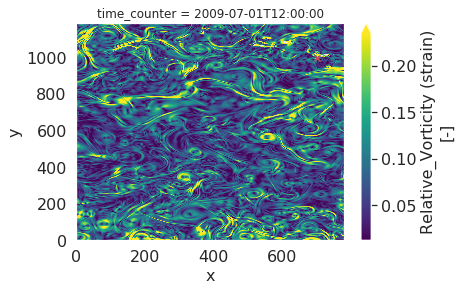

In [7]:
levels = [0.0,0.05,0.1,0.15,0.2,0.25]
fig, ax = plt.subplots()
im = strain_JAS[0].plot(cbar_kwargs={"ticks": levels, "spacing":"proportional"},robust=True,extend='max')
ax.scatter(700,1000,marker='x',color='r')

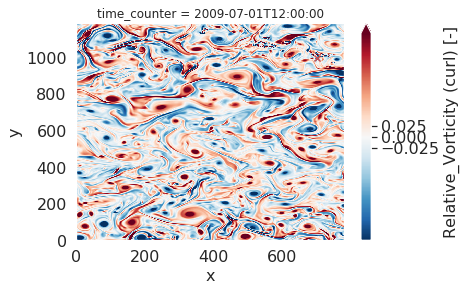

In [8]:
levels = [-0.5,-0.025,0.0,0.025,0.5]
fig, ax = plt.subplots()
im = curl_JAS[0].plot(cbar_kwargs={"ticks": levels, "spacing":"proportional"},robust=True,extend='max')
ax.scatter(700,1000,marker='x',color='r')

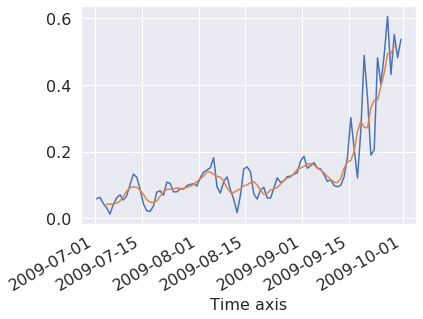

In [9]:
strain_JAS_1pt.plot(label='full data')
strain_JAS_1pt.rolling(time_counter=6,center=True).mean().plot(label='rolling daily mean')

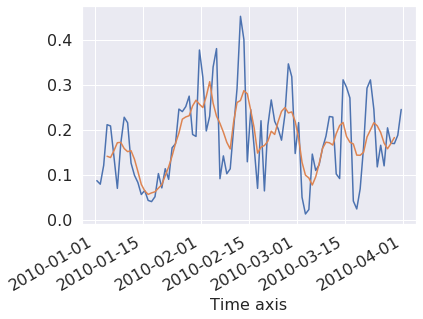

In [10]:
strain_JFM_1pt.plot(label='full data')
strain_JFM_1pt.rolling(time_counter=6,center=True).mean().plot(label='rolling daily mean')

### FFT decomposition and power spectral density computation

In [11]:
NPADDING = 2
SPtime_JAS = xfft.fft(strain_JAS_1pt, dim='time_counter', dx=1., detrend='mean',nfft=strain_JAS_1pt.shape[0]*NPADDING,tapering=True)
MEANPSD_JAS=xfft.psd(SPtime_JAS).load()
freqs_JAS=MEANPSD_JAS.f_time_counter.values
freqs_JAS = freqs_JAS[NPADDING::] 

NPADDING = 2
SPtime_JFM = xfft.fft(strain_JFM_1pt, dim='time_counter', dx=1., detrend='mean',nfft=strain_JFM_1pt.shape[0]*NPADDING,tapering=True)
MEANPSD_JFM=xfft.psd(SPtime_JFM).load()
freqs_JFM=MEANPSD_JFM.f_time_counter.values
freqs_JFM = freqs_JFM[NPADDING::] 

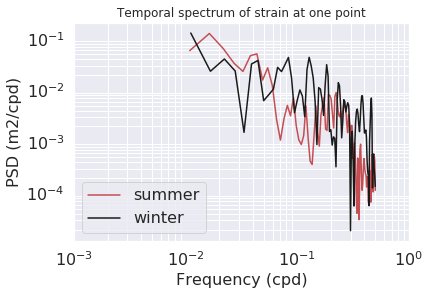

In [12]:
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)

ax.loglog(freqs_JAS,MEANPSD_JAS[NPADDING::],'r',label='summer')
ax.loglog(freqs_JFM,MEANPSD_JFM[NPADDING::],'k',label='winter')
ax.set_xlim(1e-3,1)
ax.grid(which='both',axis='both')
plt.xlabel('Frequency (cpd)')
plt.ylabel('PSD (m2/cpd)')
plt.legend()
plt.title('Temporal spectrum of strain at one point')
plt.savefig('Temporal_spectrum_strain_1point'+'.png',dpi=100,bbox_inches='tight',pad_inches=0.1)


In [13]:
NPADDING = 2
SPtime_JAS = xfft.fft(curl_JAS_1pt, dim='time_counter', dx=1., detrend='mean',nfft=curl_JAS_1pt.shape[0]*NPADDING,tapering=True)
MEANPSD_JAS=xfft.psd(SPtime_JAS).load()
freqs_JAS=MEANPSD_JAS.f_time_counter.values
freqs_JAS = freqs_JAS[NPADDING::] 

NPADDING = 2
SPtime_JFM = xfft.fft(curl_JFM_1pt, dim='time_counter', dx=1., detrend='mean',nfft=curl_JFM_1pt.shape[0]*NPADDING,tapering=True)
MEANPSD_JFM=xfft.psd(SPtime_JFM).load()
freqs_JFM=MEANPSD_JFM.f_time_counter.values
freqs_JFM = freqs_JFM[NPADDING::] 

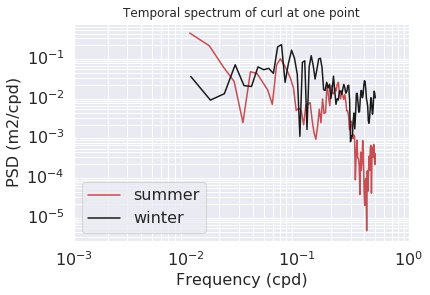

In [14]:
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)

ax.loglog(freqs_JAS,MEANPSD_JAS[NPADDING::],'r',label='summer')
ax.loglog(freqs_JFM,MEANPSD_JFM[NPADDING::],'k',label='winter')
ax.set_xlim(1e-3,1)
ax.grid(which='both',axis='both')
plt.xlabel('Frequency (cpd)')
plt.ylabel('PSD (m2/cpd)')
plt.legend()
plt.title('Temporal spectrum of curl at one point')
plt.savefig('Temporal_spectrum_curl_1point'+'.png',dpi=100,bbox_inches='tight',pad_inches=0.1)
